In [78]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../HOTS'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/antoine/homhots/HOTS/HOTS


In [79]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [92]:
def makeve():
    x = torch.randint(0,34,[4000])
    y = torch.randint(0,34,[4000])
    p = torch.randint(0,1,[4000])
    t, ind = torch.randint(0,3000,[10000]).sort()
    t = torch.unique(t)
    n_events = len(t)
    x, y, p = x[:n_events, None], y[:n_events, None], p[:n_events, None]

    events = torch.cat([x,y,t[:, None],p],dim=1)
    x_index, y_index, t_index, p_index = 0, 1, 2, 3
    return events, n_events, x_index, y_index, t_index, p_index

In [81]:
import tonic

eventset = tonic.datasets.NMNIST(save_to='../Data/',
                                train=False,
                                transform=None)
loader = tonic.datasets.DataLoader(eventset, shuffle=True)

eventonic, target = next(iter(loader))
print(torch.squeeze(eventonic).shape, eventset.ordering)

Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/
torch.Size([2908, 4]) xytp


# Parameters

In [82]:
sample_space = 1
sample_events = 1
sensor_size = [34,34]
N_p = 2
tau = torch.tensor(1500)

# With simple loop from get_data()

In [83]:
events, n_events, x_index, y_index, t_index, p_index = makeve()
print(events)

torch.Size([2891, 4])
tensor([[   4,   12,    0,    0],
        [  14,    3,    1,    0],
        [  25,   11,    2,    0],
        ...,
        [  27,   28, 2997,    0],
        [  27,   14, 2998,    0],
        [   7,    6, 2999,    0]])


In [93]:
%%timeit
events, n_events, x_index, y_index, t_index, p_index = makeve()

c_int = lambda n, d : ((n - 1) // d) + 1

data = torch.zeros((c_int(sensor_size[0],sample_space),
                     c_int(sensor_size[1],sample_space),
                     N_p))

X = np.zeros((c_int(n_events, sample_events), len(torch.flatten(data))))
    #y = np.zeros((c_int(n_events, sample_events), ))
for i_event in range(1, n_events):
    data *= torch.exp(-(events[i_event,t_index]-events[i_event-1,t_index])/tau)

    x_pos = events[i_event,x_index]//sample_space
    y_pos = events[i_event,y_index]//sample_space
    p = events[i_event,p_index]
    data[int(x_pos), int(y_pos), int(p)] = 1.

    if i_event % sample_events == sample_events//2:
        X[i_event//sample_events, :] = torch.flatten(data)

279 ms ± 4.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
c_int = lambda n, d : ((n - 1) // d) + 1

data = torch.zeros((c_int(sensor_size[0],sample_space),
                     c_int(sensor_size[1],sample_space),
                     N_p))

X = np.zeros((c_int(n_events, sample_events), len(torch.flatten(data))))
    #y = np.zeros((c_int(n_events, sample_events), ))
for i_event in range(1, n_events):
    data *= torch.exp(-(events[i_event,t_index]-events[i_event-1,t_index])/tau)

    x_pos = events[i_event,x_index]//sample_space
    y_pos = events[i_event,y_index]//sample_space
    p = events[i_event,p_index]
    data[int(x_pos), int(y_pos), int(p)] = 1.

    if i_event % sample_events == sample_events//2:
        X[i_event//sample_events, :] = torch.flatten(data)

(2891, 2312) torch.Size([2891, 4])


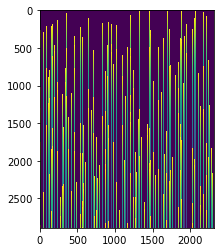

In [86]:
print(X.shape,events.shape)
plt.imshow(X)

In [ ]:
events, n_events, x_index, y_index, t_index, p_index = makeve()
print(events)

In [94]:
%%timeit
events, n_events, x_index, y_index, t_index, p_index = makeve()
t = events[:,t_index].clone().detach()
events[:,2] = events[:,p_index].clone().detach()
events[:,3] = torch.arange(0,events.shape[0])
p_index = 2

E = torch.ones(n_events)
R = torch.sparse.FloatTensor(events.T, E, torch.Size([34, 34, 2, n_events])).to_dense()
for i in range(len(t)):
    t_pos = t[i]
    dt = t_pos-t
    s = np.exp(dt/tau)
    s[s>1]=0
    #print(R.shape,events[i,p_index],p_index)
    R[events[i,x_index],events[i,y_index],events[i,p_index],:]+=s # /!\ de cette manière on cumule les évènements
R = torch.flatten(R,0,2)

429 ms ± 8.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [88]:
print(torch.sum(R),len(t))

tensor(2372080.5000) 2887


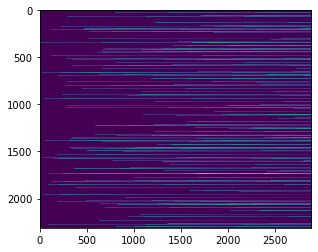

In [89]:
plt.imshow(R)

In [28]:
i = 10
M,N = R.shape
t_pos = t[i]

In [44]:
dt = t_pos-t
s = np.exp(dt/tau)
s[s>1]=0

tensor([   11,    10,     9,  ..., -2986, -2987, -2988])
tensor(1.)


In [32]:
R[]

tensor([[   2,   24,    0,    0],
        [  18,   23,    0,    1],
        [  19,   19,    0,    2],
        ...,
        [   9,   17,    0, 2900],
        [  31,   30,    0, 2901],
        [   6,    0,    0, 2902]])


In [37]:
M,N = R.shape
t_pos = t[i]
a = np.ones([N-i,N-i])
a = np.triu(a)
b = np.zeros([i,i])
print(M,N,a.shape, b.shape)
A = np.concatenate([b,b])
B = np.concatenate([b,a])
C = np.concatenate([A.T,B.T])
print(C)
#print(np.triu(a))

2312 2903 (2893, 2893) (10, 10)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 10 and the array at index 1 has size 2893

7524